In [1]:
import os.path as osp
from helper import find_best_model_in_metric_file  
import matplotlib.pylab as plt
from collections import  defaultdict
from general_tools.simpletons import sort_dict_by_key
from operator import itemgetter
import numpy as np

In [2]:
%matplotlib inline

In [3]:
top_sample_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/'
top_evaluation_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/synthetic_data/'

In [22]:
def color_of_model(name):
    colorings = {
        'gmm': 'purple',        
        'l_w_gan_small': 'blue',
        'l_w_gan_large': 'cyan',
        'l_gan_chamfer': 'green',
        'l_gan_emd': 'yellow',        
        'r_gan': 'red'
    }
    
    return colorings[name]

def legend_split_name(split):
    if split == 'val':
        return 'test'
    elif split == 'test':
        return 'val'
    else:
        return split

def exp_plot_name(name):
    names = {
        'l_w_gan_small': 'l_w_emd',
        'l_w_gan_large': 'l_w_gan_large',
        'l_gan_chamfer': 'l_cham',
        'l_gan_emd': 'l_emd',        
        'r_gan': 'r_gan'
    }
    
    return names[name]

def exp_plot_marker(name):
    names = {
        'l_w_gan_small': '*',
        'l_w_gan_large': '-',
        'l_gan_chamfer': '^',
        'l_gan_emd': 'v',        
        'r_gan': '+'
    }
    return names[name]

In [23]:
def stored_synthetic_samples(class_name):
    sample_dir = {'l_gan_emd': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128'),
                  'l_gan_chamfer': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128'),
                  'l_w_gan_small': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch'),
                  'l_w_gan_large': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch_double_neurons'),
                  'r_gan': osp.join(top_sample_dir, 'r_gan/r_gan_' + class_name + '_mlp_disc_4_fc_gen_raw_gan_2048_pts'),
                  'gmm': osp.join(top_sample_dir, 'gmm/gmm_emd_' + class_name)
                 }
    
    return sample_dir

In [24]:
def read_evaluation_file(in_file):
    all_lines = []
    res = dict()
    with open(in_file, 'r') as fin:
        for line in fin:
            l = line.rstrip()
            if len(l) > 0:
                all_lines.append(l)
    return all_lines

def tokenize_evaluation_data(in_lines):
    current_model = None
    data_dict = defaultdict(dict)
    
    def model_name(model):
        if model.startswith('epoch'):
            return int(model[len('epoch_'):])

        elif model.endswith('gaussians'):
            tok = model.split('_')
            cov_type = tok[-3]
            n_gaussians = tok[-2]
            return cov_type + '_' + n_gaussians
            
    for line in in_lines:
        token = line.split()
        if token[0] not in ['train', 'test', 'val']:
            current_model = model_name(token[0])        # Varying epoch or n_gaussians 
        else:
            try:
                split, metric_value, metric_std = token # has - mean and std
            except:
                split, metric_value = token
                metric_std = 0
                
            metric_value = float(metric_value)
            metric_std = float(metric_std)
            data_dict[split][current_model] = (metric_value, metric_std)            
    return data_dict
    
    
def find_best_model_in_metric(in_file, sort_by='test', report=['train', 'test', 'val']):    
    all_lines = read_evaluation_file(in_file)
    data_dict = tokenize_evaluation_data(all_lines)
    stats = data_dict[sort_by]
    best_model = sorted([(stats[s][0], stats[s][1], s) for s in stats.keys()])[0]
    res = dict()
    for s in report:
        if s in data_dict:
            res[s] = (best_model[2], data_dict[s][best_model[2]])        
    return res

def collect_data_for_all_experiments(exp_dict, metric):
    data_col = dict()
    for key in exp_dict.keys(): 
        exp_name = osp.basename(exp_dict[key]) 
        in_file = osp.join(top_evaluation_dir, class_name, metric, exp_name + '.txt')
        
        all_lines = read_evaluation_file(in_file)
        data_col[key] = tokenize_evaluation_data(all_lines)
    return data_col

def stats_per_epoch_or_gaussian_type(data_dict, split='train'):
    d = data_dict[split]
    x = []
    y = []
    e = []
    for key, val in sort_dict_by_key(d):
        x.append(key)
        y.append(val[0])
        e.append(val[1])
    return x, y, e

In [25]:
class_name = 'chair'
exp_dict = stored_synthetic_samples(class_name)
exp_dict.pop('l_w_gan_large', 'None')

'/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/l_w_gan/l_w_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch_double_neurons'

In [26]:
boost_5_data = collect_data_for_all_experiments(exp_dict, 'mmd_chamfer_all_gt_boosted_5_time_synthetic')
emd_100_500_data = collect_data_for_all_experiments(exp_dict, 'mmd_emd_sparse_3times_100gt_vs_500synthetic')
jsd_data = collect_data_for_all_experiments(exp_dict, 'jsd')

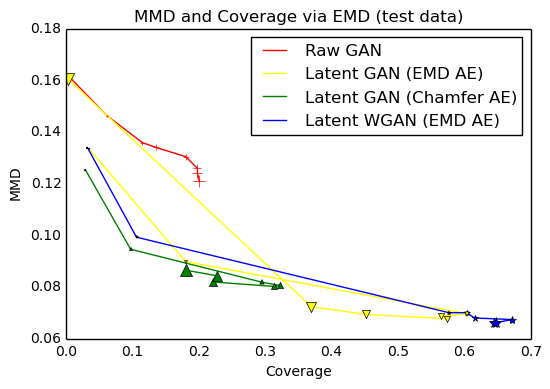

In [27]:
reduced_exp = exp_dict.copy()
reduced_exp.pop('gmm', 'None')
reduced_exp.pop('l_w_gan_large', 'None')
emd_coverage = collect_data_for_all_experiments(reduced_exp, 'emd_coverage_over_epochs_gans_boost_test_3')
emd_mmd_dense = collect_data_for_all_experiments(reduced_exp, 'emd_mmd_over_epochs_gans_boost_test_3')
split = 'val'
legend_names = []

def exp_plot_name_on_large_gap(name):
    names = {
        'l_w_gan_small': 'Latent WGAN (EMD AE)',
        'l_w_gan_large': 'l_w_gan_large',
        'l_gan_chamfer': 'Latent GAN (Chamfer AE)',
        'l_gan_emd': 'Latent GAN (EMD AE)',
        'r_gan': 'Raw GAN'
    }
    return names[name]
    
for key in ['r_gan', 'l_gan_emd', 'l_gan_chamfer', 'l_w_gan_small']:
    
    _, y1, _ = stats_per_epoch_or_gaussian_type(emd_coverage[key], split)
    _, y2, _ = stats_per_epoch_or_gaussian_type(emd_mmd_dense[key], split)    
    y2 = np.array(y2)
    y2 /= 2048
    plt.plot(y1, y2, '-', color=color_of_model(key))    
    legend_names.append(exp_plot_name_on_large_gap(key))
 
plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')
plt.legend(legend_names)
plt.title('MMD and Coverage via EMD (%s data)' % (legend_split_name(split)) )
plt.ylabel('MMD')
plt.xlabel('Coverage')

for key in reduced_exp.keys():
    _, y1, _ = stats_per_epoch_or_gaussian_type(emd_coverage[key], split)
    _, y2, _ = stats_per_epoch_or_gaussian_type(emd_mmd_dense[key], split)    
    y2 = np.array(y2)
    y2 /= 2048    
    for m in range(len(y1)):
        plt.plot(y1[m], y2[m], marker=exp_plot_marker(key), color=color_of_model(key), markersize=(m+1) )

In [13]:
legend_names = []
split = 'val'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(boost_5_data[key], split)
        plt.plot(x1, y1, '*', color=color_of_model(key))        
        legend_names.append(exp_plot_name(key))

plt.xticks(x1, x1, rotation='vertical')    
plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')

plt.legend(legend_names)
plt.title('MMD-CD vs epochs (%s data)' % (legend_split_name(split)) )
plt.ylabel('MMD-CD')
plt.xlabel('Epochs')

In [14]:
legend_names = []
split = 'val'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(emd_100_500_data[key], split)
        plt.plot(x1, y1, '*', color= color_of_model(key))        
        legend_names.append(exp_plot_name(key))

# plt.xticks(x1, x1, rotation='vertical')    
plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')

plt.legend(legend_names, loc=2)
plt.title('MMD-EMD vs epochs (%s data)' % (legend_split_name(split)) )
plt.ylabel('MMD-EMD')
plt.xlabel('Epochs')


In [15]:
legend_names = []
split = 'val'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], split)
        plt.plot(x1, y1, '*', color=color_of_model(key))
        legend_names.append(exp_plot_name(key))

plt.xticks(x1, x1, rotation='vertical')    
plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')

plt.legend(legend_names)
plt.title('JSD vs epochs (%s data)' % (legend_split_name(split)) )
plt.ylabel('JSD')
plt.xlabel('Epochs')

In [16]:
# legend_names = []
# split = 'train'
# for key in ['l_gan_emd', 'l_w_gan_small', 'r_gan']:
#     x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'train')
#     plt.plot(x1, y1)
#     legend_names.append(exp_plot_name(key) + '_train')
#     x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'val')
#     plt.plot(x1, y1)
#     legend_names.append(exp_plot_name(key) + '_test')
    
# plt.legend(legend_names)
# plt.title('JSD in Train and Test')
# plt.ylabel('JSD')
# plt.xlabel('Epochs')

In [17]:
# legend_names = []
# split = 'train'
# for key in ['gmm']:
#     labels, y, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'train')    
#     labels_ = [l.split('_')for l in labels]
#     labels_ = [(l[0], int(l[1])) for l in labels_]
#     arg_labels = sorted(enumerate(labels_), key=itemgetter(1))
#     labels = [l[1] for l in arg_labels]
#     arg_y = [l[0] for l in arg_labels]
#     x = np.arange(len(labels))
#     plt.scatter(x, np.array(y)[arg_y])
#     plt.xticks(x, labels, rotation='vertical')    
#     plt.title('JSD of GMMs')
#     plt.ylabel('JSD')
#     plt.xlabel('cov,n_clusters')    
#     plt.tick_params(axis='x', which='both', bottom='off', top='off')
#     plt.tick_params(axis='y', which='both', left='off', right='off')

In [41]:
# TODO
# Add the average coverage below as a print-out
# Double-check that on a single method thinks look ok - (manually)
# Only report for the non-sort method the "val" (print it out as test to be done.)
'mmd_chamfer_all_gt_boosted_5_time_synthetic'
# 'mmd_emd_sparse_3times_100gt_vs_500synthetic'
# 'jsd'

sort_by_metric = 'jsd'
report_metric_at = ['train', 'test', 'val']
legend_names = []
for key in exp_dict.keys():
    print key
    exp_name = osp.basename(exp_dict[key]) 
    in_file = osp.join(top_evaluation_dir, class_name, sort_by_metric, exp_name + '.txt')
    best_model = find_best_model_in_metric(in_file, sort_by='test', report=report_metric_at)
    best_id = best_model['test'][0]
    print 'best epoch', best_id
    for split in metric_eval_at:
        print sort_by_metric, split, '%f' %(best_model[split][1][0], )
        
        if split in boost_5_data[key] and not 'mmd' in sort_by_metric:
            st = boost_5_data[key][split][best_id]
            print 'cd_boost_5 %s %f %f' % (split, st[0], st[1])
        
        if split in emd_100_500_data[key]:
            st = emd_100_500_data[key][split][best_id]
            print 'emd_100_500 %s %f %f' %(split, st[0] / float(2048), st[1] / float(2048))
        
        
# #         if split in jsd_data[key]:
# #             st = jsd_data[key][split][best_id]
# #             print 'jsd %.4f' %(st[0])

l_w_gan_large
best epoch 1800
jsd train 0.005757
emd_100_500 train 0.065281 0.001127
jsd test 0.012905
cd_boost_5 test 0.001636 0.000899
jsd val 0.023214
cd_boost_5 val 0.001829 0.001078
emd_100_500 val 0.066818 0.000846
gmm
best epoch full_32
jsd train 0.004899
emd_100_500 train 0.065005 0.000931
jsd test 0.011660
cd_boost_5 test 0.001633 0.000893
jsd val 0.019508
cd_boost_5 val 0.001786 0.000986
emd_100_500 val 0.067381 0.000817
r_gan
best epoch 1700
jsd train 0.166009
emd_100_500 train 0.123539 0.000802
jsd test 0.168318
cd_boost_5 test 0.001820 0.001093
jsd val 0.174396
cd_boost_5 val 0.002007 0.001294
emd_100_500 val 0.122466 0.000800
l_gan_chamfer
best epoch 300
jsd train 0.037284
emd_100_500 train 0.082206 0.001701
jsd test 0.039282
cd_boost_5 test 0.001732 0.001117
jsd val 0.043295
cd_boost_5 val 0.001951 0.001422
emd_100_500 val 0.079817 0.001062
l_w_gan_small
best epoch 1800
jsd train 0.007762
emd_100_500 train 0.066263 0.000734
jsd test 0.015172
cd_boost_5 test 0.001703 0.00